In [191]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.models as models
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import seaborn as sns


In [2]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [19]:
# Load MNIST dataset
batch_size = 64
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)


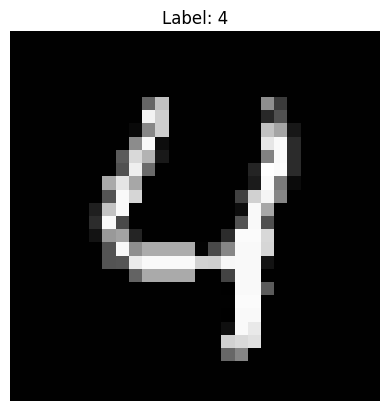

In [187]:
# Access the first image and its label
first_image, first_label = testset[4]

# Convert the tensor back to a PIL image for visualization
first_image_pil = transforms.ToPILImage()(first_image)

# Display the image and label
plt.imshow(first_image_pil, cmap='gray')
plt.title(f"Label: {first_label}")
plt.axis('off')
plt.show()

In [5]:
# Define the model, loss function, and optimizer
net = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


In [ ]:
# Training loop
num_epochs = 10  # You can adjust the number of training epochs
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(trainloader)}')

print('Finished Training')

Epoch [1/10] Loss: 0.24878639661556065
Epoch [2/10] Loss: 0.06472418259512554
Epoch [3/10] Loss: 0.04356077132172692
Epoch [4/10] Loss: 0.03322461403618161
Epoch [5/10] Loss: 0.023998529542605382
Epoch [6/10] Loss: 0.018492115905269734
Epoch [7/10] Loss: 0.014650754255752987
Epoch [8/10] Loss: 0.011086338368375685
Epoch [9/10] Loss: 0.00995450312275003
Epoch [10/10] Loss: 0.007264895159367832
Finished Training


In [ ]:
# Save the trained model
torch.save(net.state_dict(), 'simple_CNN.pth')

In [6]:
# Load the model back
simple_cnn = SimpleCNN()
simple_cnn.load_state_dict(torch.load('simple_CNN.pth'))
simple_cnn.eval()  # Set the model to evaluation mode

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [185]:
# Define data transformations for FashionMNIST
transform_fashion = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FashionMNIST dataset
batch_size = 64
fashion_testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_fashion)
fashion_testloader = torch.utils.data.DataLoader(fashion_testset, batch_size=batch_size, shuffle=False)


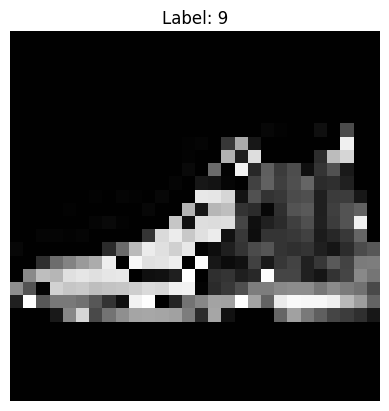

In [186]:
# Access the first image and its label
first_image, first_label = fashion_testset[0]

# Convert the tensor back to a PIL image for visualization
first_image_pil = transforms.ToPILImage()(first_image)

# Display the image and label
plt.imshow(first_image_pil, cmap='gray')
plt.title(f"Label: {first_label}")
plt.axis('off')
plt.show()

In [129]:
def get_softmax_scores(model, dataloader):
    scores = []
    outputs_raw = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            outputs = model(inputs)
            softmax_scores = F.softmax(outputs, dim=1)
            scores.append(softmax_scores)
            outputs_raw.append(outputs)
    scores = torch.cat(scores)
    outputs_raw = torch.cat(outputs_raw)
    return scores,outputs_raw

In [107]:
print(testloader)

In [130]:
mnist_softmax_scores,scores_mnist = get_softmax_scores(simple_cnn, testloader)  # MNIST softmax scores (ID)
fashion_softmax_scores,scores_fashion = get_softmax_scores(simple_cnn, fashion_testloader)  # FashionMNIST softmax scores (OOD)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [43]:
print(torch.sum(mnist_softmax_scores[0]))

tensor(1.)


In [131]:
print(scores_mnist.shape)

torch.Size([10000, 10])


In [132]:
print(mnist_softmax_scores.shape)


torch.Size([10000, 10])


In [133]:
print(torch.sum(mnist_softmax_scores[0]))

tensor(1.)


In [194]:
threshold = 0.9  # Adjust as needed

def classify_samples(softmax_scores, threshold):
    max_scores, _ = torch.max(softmax_scores, dim=1)
    ood_samples = max_scores < threshold
    return ood_samples,max_scores

In [195]:
mnist_ood_samples,max_mnist = classify_samples(mnist_softmax_scores, threshold)
fashion_ood_samples,max_fashion = classify_samples(fashion_softmax_scores, threshold)

<ipython-input-197-f4c328f624db>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(max_mnist, shade=True, color = "blue")
<ipython-input-197-f4c328f624db>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(max_fashion, shade=True, color = "yellow")


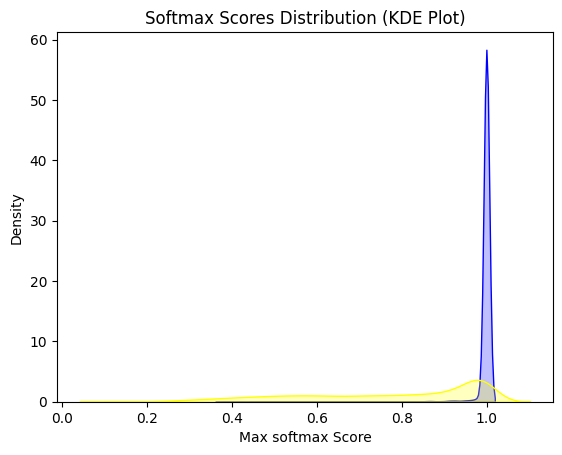

In [197]:
# Create a KDE plot
sns.kdeplot(max_mnist, shade=True, color = "blue")
sns.kdeplot(max_fashion, shade=True, color = "yellow")


# Customize the plot
plt.xlabel("Max softmax Score")
plt.ylabel("Density")
plt.title("Softmax Scores Distribution (KDE Plot)")

# Display the plot or save it to a file
plt.show()

In [114]:
print(torch.sum(mnist_ood_samples).item())
print(torch.sum(fashion_ood_samples).item())

184
5968


In [134]:
d=2
def energy(out, axis = 1, numpy = True, T = 1, correction = False , ty='not_num'): #actually takes negative energy
    print("Called")

    if ty == 'not_num':
      #print("correct")
      out = out.detach().numpy()

      #print(out)
      #denominator of softmax np.sum(np.exp(out/T)
      scores = T*np.log(np.sum(np.exp(out/T), axis = axis))
    if correction:
      print("here")
      scores -= T*np.log(d)

    return scores

In [135]:
print(scores_mnist.shape)

torch.Size([10000, 10])


In [148]:
# Energy Scores
ID_energy_score = energy(scores_mnist)
OOD_energy_score = energy(scores_fashion)


Called
Called


In [149]:
print(ID_energy_score)
print(OOD_energy_score)

[20.270672 25.159874 13.932249 ... 28.565504 25.746426 19.249998]
[7.619541  7.2831483 7.247143  ... 6.3047795 6.108951  4.079705 ]


<ipython-input-172-0bac3853979a>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ID_energy_score, shade=True, color = "blue")
<ipython-input-172-0bac3853979a>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(OOD_energy_score, shade=True, color = "yellow")


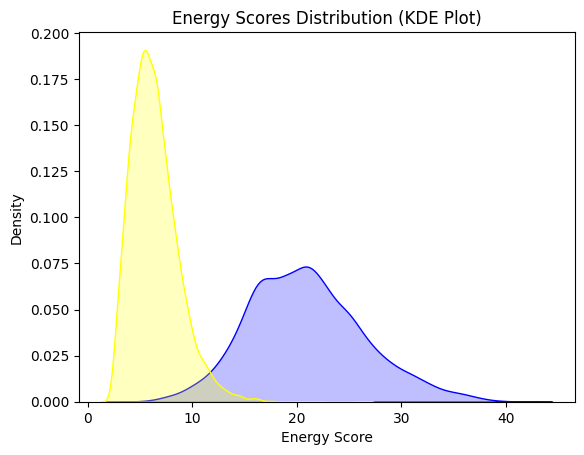

In [172]:
# Create a KDE plot
sns.kdeplot(ID_energy_score, shade=True, color = "blue")
sns.kdeplot(OOD_energy_score, shade=True, color = "yellow")


# Customize the plot
plt.xlabel("Energy Score")
plt.ylabel("Density")
plt.title("Energy Scores Distribution (KDE Plot)")

# Display the plot or save it to a file
plt.show()


In [190]:
t = 10.0
ID_OOD = ID_energy_score < t
OOD = OOD_energy_score < t

(10000,)


In [181]:

print(np.sum(ID_OOD).item())
print(np.sum(OOD).item())

157
9311
